# Exploration of the features evaluation
The following notebook evaluates the different combinations of features (electrode groups, frequency bands)
by optimizing random forests and logistic regression on each combination.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
sys.path.append('.')
sns.set_theme()
%load_ext autoreload
%autoreload 2

## Evaluating through random forests
Run the following script to evaluate each combination using a Random Forest Classifier:  
```python scripts/evaluate_features.py random_forest```  
The model uses the clean data of subject 1 day 4, and tries a maximum depth of 3 nodes. While we noticed that a depth of more than three
does not improve the results, it especially allows for better interpretation.

Load the results as a pandas DataFrame:

In [2]:
rfc_df = pd.read_csv(os.path.join('evaluations', 'random_forest_features_evaluation.csv'))
rfc_df.head()

,Unnamed: 0,frequencies,electrodes,train_acc,train_std,acc,std,param,n_features
0,0,all,all,0.993700,0.007716,0.862500,0.091856,1,31062
1,1,all,all,1.000000,0.000000,0.862500,0.082916,2,31062
2,2,all,all,1.000000,0.000000,0.875000,0.068465,3,31062
3,3,all,right temporal,0.949405,0.011671,0.860833,0.099847,1,4509
4,4,all,right temporal,1.000000,0.000000,0.898333,0.085334,2,4509


For random forests, 'param' is the max depth of the tree.

### Best combinations
We're interested in knowing which combinations of features yield the best test results:

In [3]:
rfc_df.sort_values(by='acc', ascending=False).head(10)

,Unnamed: 0,frequencies,electrodes,train_acc,train_std,acc,std,param,n_features
172,172,"['hgamma', 'lgamma']",right temporal,0.996825,0.006349,0.912500,0.093541,2,4509
173,173,"['hgamma', 'lgamma']",right temporal,1.000000,0.000000,0.912500,0.063738,3,4509
20,20,all,central,1.000000,0.000000,0.899167,0.063268,3,9519
4,4,all,right temporal,1.000000,0.000000,0.898333,0.085334,2,4509
171,171,"['hgamma', 'lgamma']",right temporal,0.949405,0.011671,0.887500,0.100000,1,4509
21,21,all,"['right temporal', 'left temporal']",0.965228,0.006052,0.887500,0.100000,1,9018
188,188,"['hgamma', 'lgamma']",central,1.000000,0.000000,0.886667,0.072332,3,9519
19,19,all,central,1.000000,0.000000,0.886667,0.045901,2,9519
10,10,all,parietal,1.000000,0.000000,0.875000,0.079057,2,12525
11,11,all,parietal,1.000000,0.000000,0.875000,0.068465,3,12525


It appears that the best models reach around 0.85 to 0.9 test accuracy. Since the dataset only includes
79 samples, the test subsets only contain 15 or 16 of them (since 5 cross-validation folds were used).  
Therefore, a slight difference in accuracy should not be interpreted as a necessary much better model.

### The most important brain area ?
We can now have a look at the results grouped by brain area:

In [4]:
areas_results_rf = rfc_df[['electrodes', 'acc', 'std']].groupby('electrodes').mean().sort_values(by='acc', ascending=False)
areas_results_rf

,acc,std
electrodes,,
right temporal,0.722535,0.094899
"['right temporal', 'left temporal']",0.684861,0.101435
central,0.684271,0.090305
all,0.682569,0.095822
parietal,0.675625,0.079199
frontal,0.622778,0.087967
left temporal,0.616806,0.103463
occipital,0.532118,0.092510


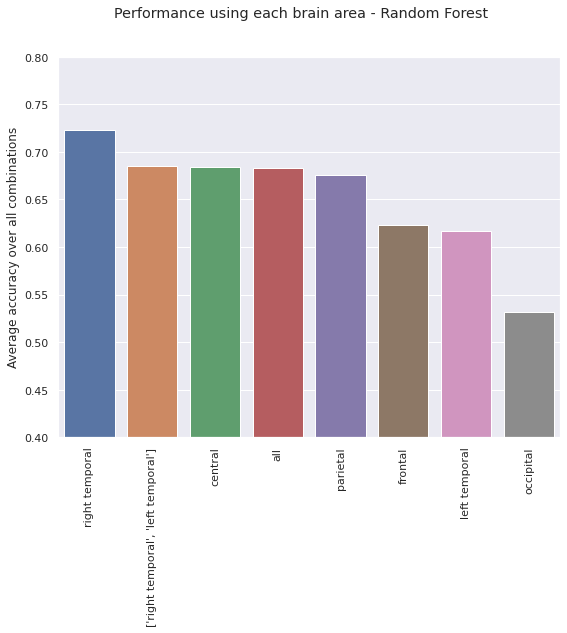

In [5]:
plt.figure(figsize=(8, 7))
sns.barplot(x=areas_results_rf.index, y=areas_results_rf['acc'])
plt.xticks(np.arange(len(areas_results_rf.index)), areas_results_rf.index, rotation=90)
plt.ylim(0.4, 0.8)
plt.suptitle('Performance using each brain area - Random Forest')
plt.ylabel('Average accuracy over all combinations')
plt.xlabel(None)
plt.savefig(os.path.join('figures', 'areas_perfs_rf.png'))
plt.show()

### The most important frequencies ?

In [6]:
freqs_results_rf = rfc_df[['frequencies', 'acc', 'std']].groupby('frequencies').mean().sort_values(by='acc', ascending=False)
freqs_results_rf

,acc,std
frequencies,,
all,0.807569,0.083982
"['hgamma', 'lgamma']",0.788924,0.084468
hgamma,0.774583,0.083543
lgamma,0.691354,0.103743
theta,0.560451,0.090533
beta,0.551667,0.120905
alpha,0.551146,0.083891
delta,0.495868,0.094535


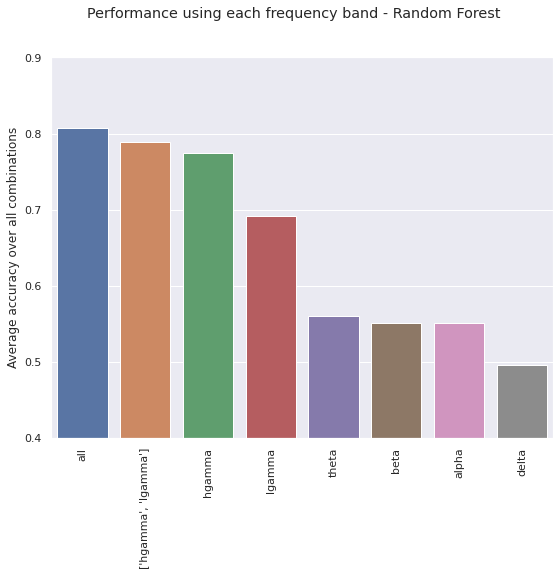

In [7]:
plt.figure(figsize=(8, 7))
sns.barplot(x=freqs_results_rf.index, y=freqs_results_rf['acc'])
plt.xticks(np.arange(len(freqs_results_rf.index)), freqs_results_rf.index, rotation=90)
plt.ylim(0.4, 0.9)
plt.suptitle('Performance using each frequency band - Random Forest')
plt.ylabel('Average accuracy over all combinations')
plt.xlabel(None)
plt.savefig(os.path.join('figures', 'freqs_perfs_rf.png'))
plt.show()

Clearly the higher frequencies give more information regarding the syllable that the subject is imagining.

### Does the forest need depth ?
The classification accuracies reach high values without increasing the trees' depths over 3, which is relatively shallow. This low depth
allows us to use more trees (300 in the experiment) while training the models very quickly.

In [8]:
param_results = rfc_df[['param', 'acc', 'std']].groupby('param').mean().sort_values(by='acc', ascending=False)
param_results

,acc,std
param,,
3,0.654466,0.092683
2,0.652122,0.096890
1,0.651497,0.090027


It seems that the depth does not make that much of a difference.

### Evaluating the best model on other days
We will now evaluate the best features for all days, and compare them to a baseline model
which uses all features with all electrodes.

In [9]:
from scripts.evaluate_model import evaluate

In [10]:
# Avg accuracy of the best features, over each day
# For each day, estimates the performances of a random forest on those
# features and hyperparameters using cross-validation
all_days_accs = [
evaluate('random_forest', day=day, areas='right temporal', freq_bands=['hgamma', 'lgamma'], max_depth=3, use_clean_data=True)[1][0]
    for day in range(1, 6)
]
# Baseline model: all frequencies, all channels
baseline_accs = [
evaluate('random_forest', day=day, areas='all', freq_bands='all', max_depth=3, use_clean_data=True)[1][0]
    for day in range(1, 6)
]

Selecting electrodes groups right temporal
Selecting frequency band [25, 70]
Selecting electrodes groups right temporal
Selecting frequency band [25, 70]
Selecting electrodes groups right temporal
Selecting frequency band [25, 70]
Selecting electrodes groups right temporal
Selecting frequency band [25, 70]
Selecting electrodes groups right temporal
Selecting frequency band [25, 70]
Selecting frequency band [1, 100]    
Selecting frequency band [1, 100]    
Selecting frequency band [1, 100]    
Selecting frequency band [1, 100]    
Selecting frequency band [1, 100]    


We also compare those models to using the FFT of the difference between each electrodes, and to the spectrograms
of the signals:

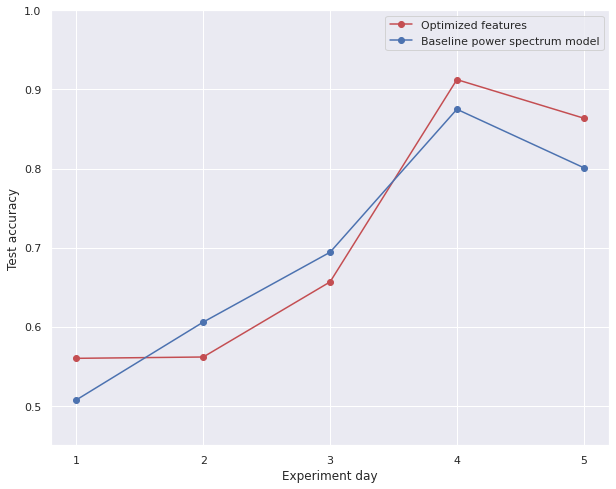

In [11]:
plt.figure(figsize=(10, 8))
days = np.arange(1, 6)
plt.plot(days, all_days_accs, "ro-")
plt.plot(days, baseline_accs, 'bo-')
plt.ylabel('Test accuracy')
plt.xlabel('Experiment day')
plt.xticks(days)
plt.ylim(0.45, 1)
plt.legend(['Optimized features', 'Baseline power spectrum model', 'FFT of pair differences', 'Spectrograms'])
plt.savefig('features_days_comp_rf.png')
plt.show()

## Evaluation through logistic regression
The following will evaluate the best model for each features combination using a logistic regression:  
```python scripts/evaluate_features.py random_forest```  
The regression is adjusted using Ridge regularization.

In [12]:
lr_df = pd.read_csv(os.path.join('evaluations', 'logistic_regression_features_evaluation.csv'))
lr_df = lr_df.sort_values(by='acc', ascending=False)
lr_df.head(10)

,Unnamed: 0,frequencies,electrodes,train_acc,train_std,acc,std,param,n_features
58,58,hgamma,right temporal,1.000000,0.000000,0.873333,0.068546,10.0,4509
59,59,hgamma,right temporal,1.000000,0.000000,0.873333,0.068546,100.0,4509
88,88,hgamma,central,1.000000,0.000000,0.861667,0.091188,10.0,9519
57,57,hgamma,right temporal,0.981002,0.006375,0.860833,0.091689,1.0,4509
89,89,hgamma,central,1.000000,0.000000,0.849167,0.092774,100.0,9519
87,87,hgamma,central,0.993651,0.007776,0.849167,0.083931,1.0,9519
93,93,hgamma,"['right temporal', 'left temporal']",1.000000,0.000000,0.848333,0.084352,1.0,9018
94,94,hgamma,"['right temporal', 'left temporal']",1.000000,0.000000,0.848333,0.084352,10.0,9018
95,95,hgamma,"['right temporal', 'left temporal']",1.000000,0.000000,0.848333,0.115608,100.0,9018
346,346,"['hgamma', 'lgamma']",right temporal,1.000000,0.000000,0.847500,0.076404,10.0,4509


The 'param' column indicates the inverse of the regularization weight (the higher the param, the less the model
is penalized).  
As expected, the logistic regression needs that the number of features be limited to perform well on unseen samples.

### Brain areas comparison

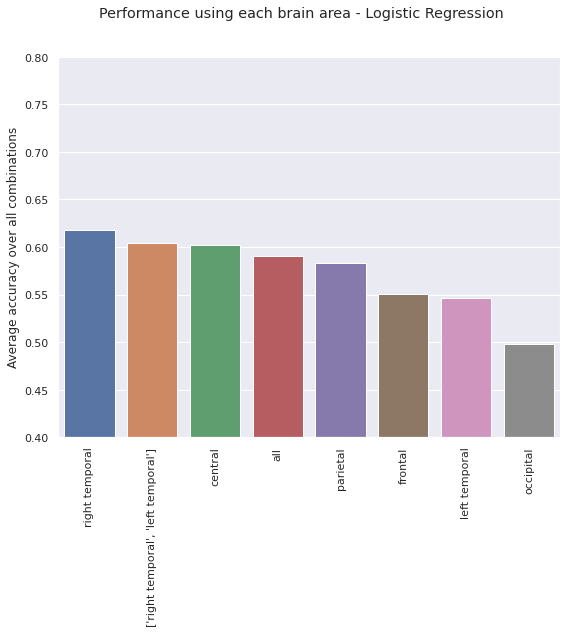

In [13]:
plt.figure(figsize=(8, 7))
areas_results_lr = lr_df[['electrodes', 'acc', 'std']].groupby('electrodes').mean().sort_values(by='acc', ascending=False)
sns.barplot(x=areas_results_lr.index, y=areas_results_lr['acc'])
plt.xticks(np.arange(len(areas_results_lr.index)), areas_results_lr.index, rotation=90)
plt.ylim(0.4, 0.8)
plt.suptitle('Performance using each brain area - Logistic Regression')
plt.ylabel('Average accuracy over all combinations')
plt.xlabel(None)
plt.savefig(os.path.join('figures', 'areas_perfs_lr.png'))
plt.show()

### Frequencies importance

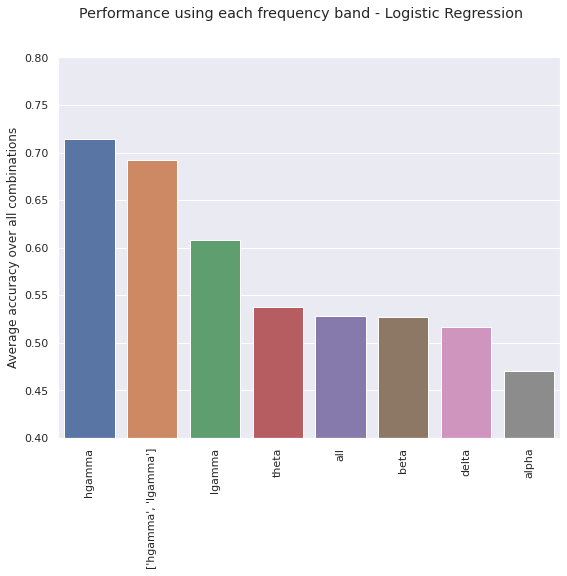

In [14]:
plt.figure(figsize=(8, 7))
freqs_results_lr = lr_df[['frequencies', 'acc', 'std']].groupby('frequencies').mean().sort_values(by='acc', ascending=False)
sns.barplot(x=freqs_results_lr.index, y=freqs_results_lr['acc'])
plt.xticks(np.arange(len(freqs_results_lr.index)), freqs_results_lr.index, rotation=90)
plt.ylim(0.4, 0.8)
plt.suptitle('Performance using each frequency band - Logistic Regression')
plt.ylabel('Average accuracy over all combinations')
plt.xlabel(None)
plt.savefig(os.path.join('figures', 'freqs_perfs_lr.png'))
plt.show()

### Comparisons to other features

In [15]:
# Avg accuracy of the best features, over each day
# For each day, estimates the performances of a random forest on those
# features and hyperparameters using cross-validation
all_days_accs = [
evaluate('logistic_regression', day=day, areas='right temporal', freq_bands='hgamma', C=10.0, use_clean_data=True)[1][0]
    for day in range(1, 6)
]
# Baseline model: all frequencies, all channels
baseline_accs = [
evaluate('logistic_regression', day=day, areas='all', freq_bands='all', C=1.0, use_clean_data=True)[1][0]
    for day in range(1, 6)
]

Selecting electrodes groups right temporal
Selecting frequency band [40, 70]
Selecting electrodes groups right temporal
Selecting frequency band [40, 70]
Selecting electrodes groups right temporal
Selecting frequency band [40, 70]
Selecting electrodes groups right temporal
Selecting frequency band [40, 70]
Selecting electrodes groups right temporal
Selecting frequency band [40, 70]
Selecting frequency band [1, 100]    
Selecting frequency band [1, 100]    
Selecting frequency band [1, 100]    
Selecting frequency band [1, 100]    
Selecting frequency band [1, 100]    


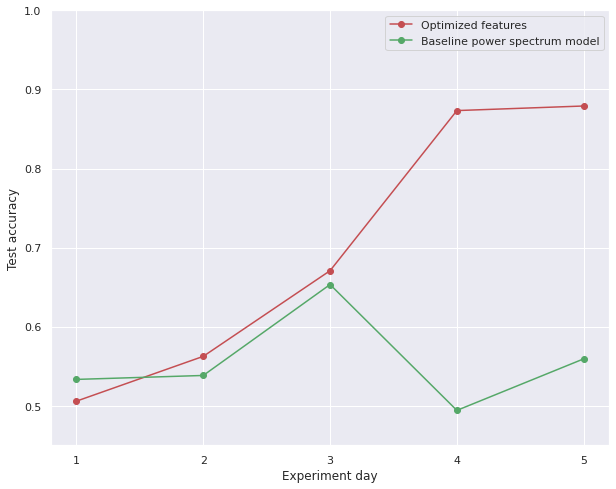

In [16]:
plt.figure(figsize=(10, 8))
days = np.arange(1, 6)
plt.plot(days, all_days_accs, "ro-")
plt.plot(days, baseline_accs, 'go-')
plt.ylabel('Test accuracy')
plt.xlabel('Experiment day')
plt.xticks(days)
plt.ylim(0.45, 1)
plt.legend(['Optimized features', 'Baseline power spectrum model'])
plt.savefig('features_days_comp_lr.png')
plt.show()

## Combining the features importance into a single barplot

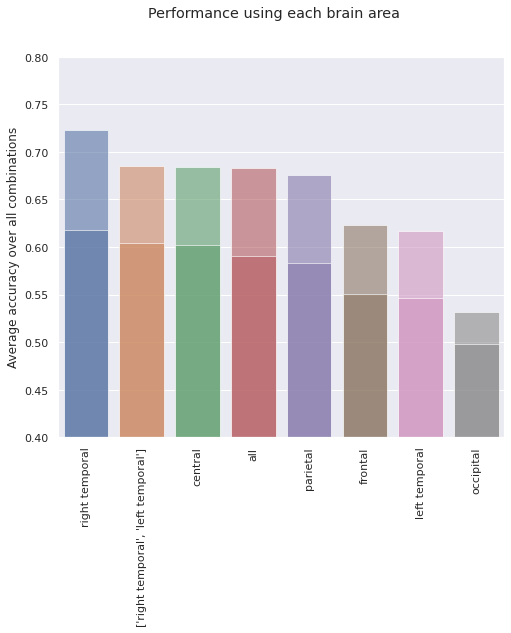

In [34]:
plt.figure(figsize=(8, 7))
sns.barplot(x=areas_results_rf.index, y=areas_results_rf['acc'], alpha=0.6)
sns.barplot(x=areas_results_lr.index, y=areas_results_lr['acc'], alpha=0.6)
plt.xticks(np.arange(len(areas_results_lr.index)), areas_results_lr.index, rotation=90)
plt.ylim(0.4, 0.8)
plt.suptitle('Performance using each brain area')
plt.ylabel('Average accuracy over all combinations')
plt.xlabel(None)
plt.savefig(os.path.join('figures', 'freqs_perfs.png'))
plt.show()

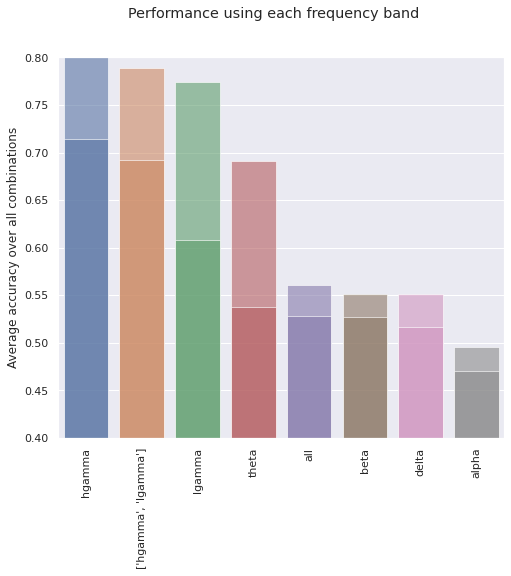

In [33]:
plt.figure(figsize=(8, 7))
sns.barplot(x=freqs_results_rf.index, y=freqs_results_rf['acc'], alpha=0.6)
sns.barplot(x=freqs_results_lr.index, y=freqs_results_lr['acc'], alpha=0.6)
plt.xticks(np.arange(len(freqs_results_lr.index)), freqs_results_lr.index, rotation=90)
plt.ylim(0.4, 0.8)
plt.suptitle('Performance using each frequency band')
plt.ylabel('Average accuracy over all combinations')
plt.xlabel(None)
plt.savefig(os.path.join('figures', 'areas_perfs.png'))
plt.show()